# Overview
Thus far, we've been calculating statistics of our neural signals. That is, we have transformed our signal (e.g., filtering or calculating a TFR), and come up with some number to summarize it (e.g., average activity across trials).

However, neuroscience is about **linking the world to brain function**, and the best way to do this is to build a *model* that links the two. This is a more explicit way of defining how a change in the world results in a change in the brain.

Today, we'll cover the basics of **modeling**. We'll start with correlation, move to univariate regression, and we'll finish with multivariate regression.

## Goals for today
* Understand correlation in context of simulated signals
* Understand correlation in the context of electrophysiology
* Relate correlation to univariate regression
* Use multivariate regression to ask more complicated questions about our data.

---

# Correlation via simulation

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import datascience as ds
import neurods as nds
%matplotlib notebook

<IPython.core.display.Javascript object>


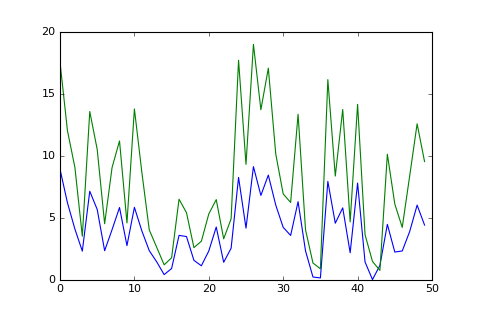

In [2]:
# We'll begin by simulating a few signals, this will help with the intuition for what regression means
# First, we'll create a random variable
noise_amp = 1
n_pts = 50
a = 10 * np.random.random(n_pts)

# Now, we'll define a "weight" that causes a second variable to respond to it
weight = 2

# Finally, we'll create some noise so that it's not a perfect mapping
noise = noise_amp * np.random.randn(n_pts)

# Then let's mix them together. In this case, b is explicitly created from the values in a
b = weight * a + noise

# Let's look at the signals
f, ax = plt.subplots()
ax.plot(a)
ax.plot(b)


> **What's the explicit relationship between these two signals?**

Before we get into modeling, we'll begin with *correlation*. Look at the two plots above, they seem to be varying in similar ways. When one goes up, the other goes up, when one goes down, the other goes down. How can we quantify this?

First, we'll use a scatterplot to see how related the two signals are

<IPython.core.display.Javascript object>


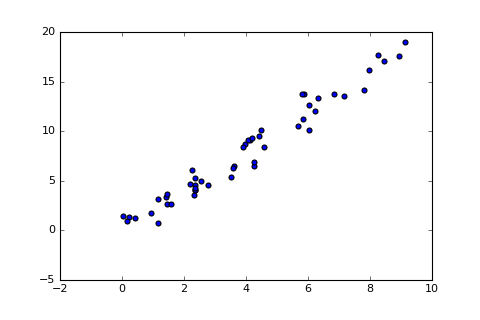

In [3]:
f, ax = plt.subplots()
ax.scatter(a, b)

Our intuition from above seem to hold here as well. When values of the x-axis are large, values on the y-axis also tend to be large. We can quantify this with the correlation coefficient.

*Note: The `corrcoef` function will actually return a "correlation matrix". In this case, every row of `a` is correlated with every row of `b`, and displayed as a matrix. Since our variables are vectors, the output will be a 2 by 2 matrix and the 1st element of the 2nd row will be the correlation coefficient.*

In [4]:
# Calculate the correlation matrix, then take the 1st val of the 2nd row.
corr = np.corrcoef(a, b)[1, 0]
print(corr)

0.980051863958


> **What would happen if we increased the noise parameter when constructing the signal above?**

# Regression via simulation

These two signals are nearly perfectly correlated, this is because above we've defined one signal to be a *linear function* of the other signal. In other words, like this:

$signal_a = w * signal_b + noise$

How is correlation related to modeling? Basically, correlation values must vary between -1 and 1. In modeling, however, we can use an arbitrary size for the weight that defines the relationship between two signals. For example, we could change the weight value above, and the underlying correlation would always be 1.

What if we wanted to recover the *actual* weight that we used, instead of a scaled correlation number? For this, we must use *regression*.

In regression, we explicitly model one signal as a linear function of the other signal. The output of regression is a *weight* (not a correlation) that tells us how we can predict values of one signal using the other.

Here's the equation for a linear model:

$$y = \sum_{i=1}^{n}w_i x_i + \epsilon$$

This says: each output $y$ is predicted by weighting each feature $x$ with by corresponding weight $w$, and summing them together, then adding random noise $\epsilon$.

Regression is a technique for inferring what these weights are, given a dataset of inputs and outputs.

There are many packages to do regression in python, but we'll focus on a Machine Learning package called `scikit-learn`.

### A quick primer on scikit-learn
Scikit-learn is **the** machine learning tool in python. It's also probably the most popular machine learning library across all languages right now. You could take an entire class JUST on machine learning with scikit-learn, but here is a very quick primer:

1. Scikit-learn contains "estimator" objects, that basically are a way of fitting different kinds of models to your data. You can create an estimator object by calling calling it (similar to a function): `myestimator = EstimatorObject()`.
2. Once you have an estimator object, you can fit it to data. Generally speaking, this means that we need *input* and *output* data. These always have a shape (n_samples, n_features).
3. We fit the estimator by using its `fit` method: `myestimator.fit(X, y)`.
4. After fitting the model to data, we can inspect the model coefficients that have been fit (these will exist as attributes created after calling `fit`, and always end in an underscore e.g.,: `myestimator.coef_`.
5. We can also use that model to predict new outputs given some inputs. We do this with the `predict` method, e.g.: `y_new = myestimator.predict(X_new)`.

We'll take a look at how to use this with some actual data below

In [5]:
# The simplest regression object solves a "Least Squares" problem.
from sklearn.linear_model import LinearRegression

In [6]:
# First, we'll add an extra dimension to both "a" and "b"
# This ensures that they are shape (n_samples, n_features)
a = a[:, np.newaxis]
b = b[:, np.newaxis]

# We'll create our regression model, and fit it to the data we created
# We won't fit an intercept, though it is easy to do so
reg = LinearRegression(fit_intercept=False)
reg.fit(a, b)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In this case, calling the `fit` method tells the model to find a set of coefficents (in this case just a single number) that, when combined with each value of "a", predicts a value of "b".

Now that the model is fit, we can access it's `coef_` attribute, or use it to predict new values:


In [7]:
# This is the relationship that the model has found between a and b
reg.coef_

array([[ 2.0013355]])

<IPython.core.display.Javascript object>


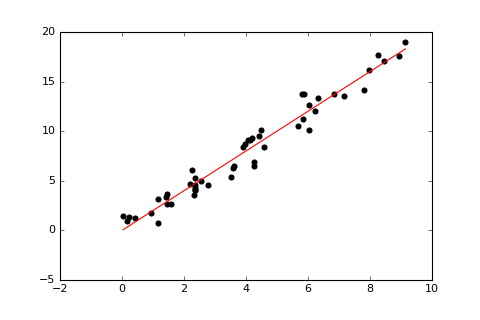

In [8]:
# To test this out, we'll create range of values that span the values in "a"
# Let's see what the model predicts for each test value:
test_vals = np.linspace(a.min(), a.max(), 50)
b_preds = reg.coef_[0] * test_vals
f, ax = plt.subplots()
ax.scatter(a, b, color='k')
ax.plot(test_vals, b_preds, color='r')

<IPython.core.display.Javascript object>


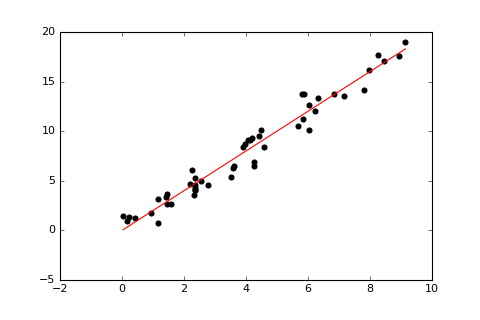

In [9]:
# We could have also just used the `predict` method of our estimator:
b_preds = reg.predict(test_vals[:, np.newaxis])

f, ax = plt.subplots()
ax.scatter(a, b, color='k')
ax.plot(test_vals, b_preds, color='r')

What's the relationship between correlation and regression? Well, if we were to convert both the inputs and the outputs into **standard units** (AKA, so they had a mean == 0, and a variance == 1), then regression would give us the exact same answer as correlation.

In scikit-learn, this is called **scaling** the data.

<IPython.core.display.Javascript object>


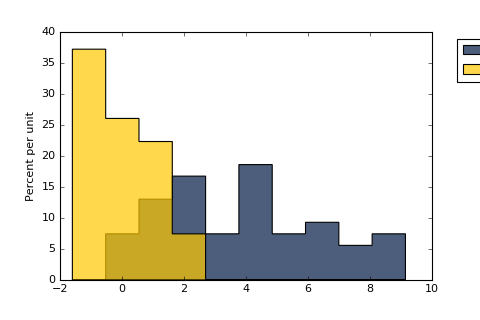

[array([[ 2.00512348],
       [ 0.90946315],
       [ 0.05207855],
       [-0.67118894],
       [ 1.2852209 ],
       [ 0.69133548],
       [-0.65722793],
       [ 0.03157823],
       [ 0.75311564],
       [-0.49130685],
       [ 0.75984874],
       [-0.01013919],
       [-0.65722776],
       [-1.02173526],
       [-1.43817131],
       [-1.23995793],
       [-0.15626913],
       [-0.19475656],
       [-0.97132216],
       [-1.15010222],
       [-0.66571713],
       [ 0.11610686],
       [-1.03597151],
       [-0.57595257],
       [ 1.73620886],
       [ 0.08002343],
       [ 2.089177  ],
       [ 1.14914077],
       [ 1.81234145],
       [ 0.83211886],
       [ 0.10516379],
       [-0.15853522],
       [ 0.94399259],
       [-0.66345042],
       [-1.51685966],
       [-1.54646457],
       [ 1.60765588],
       [ 0.24036681],
       [ 0.74206625],
       [-0.72411538],
       [ 1.55213275],
       [-1.02447343],
       [-1.60117635],
       [-1.13754559],
       [ 0.2031444 ],
       [-

In [10]:
# Scale our variables
a_scaled = (a - np.mean(a)) / np.std(a)
b_scaled = (b - np.mean(b)) / np.std(b)

# Alternatively we could do this with scikit-learn
from sklearn.preprocessing import scale
# a_scaled = scale(a)
# b_scaled = scale(b)

ds.Table().with_columns([('raw', a),
                         ('scaled', a_scaled)]).hist()

In [11]:
# Now re-run the regression
reg.fit(a_scaled, b_scaled)
coef_scaled = reg.coef_[0, 0]

# Note that the coefficient has changed:
print(coef_scaled)
print(corr)

0.980051863958
0.980051863958


> **Why isn't the coefficient exactly 1?**

Notice how using the regression model allowed us to *predict* a new output. This turns out to be really useful, and we'll cover it in future lectures. For now, we'll take these methods into our neural data...

# Regression in neural signals
One of the most challenging parts of neuroscience is figuring out how much information we can infer about the link between world and brain activity. Something that greatly affects this is how *correlated* all of our neural signals are with one another. Let's take a look at the correlations between our neural signals.

We'll use the same ECoG dataset that you used as homework last week. The subject is listening to chords - some of them are consonant, some of them a dissonant. We'd like to figure out if the brain processes consonant and dissonant chords differently.

In [12]:
# First we'll load the data. We'll load a downsampled version so that it's faster
data = mne.io.Raw('../../data/ecog/chords_task/ecog_resamp-raw.fif', preload=True)

# We'll only take the first 3 minutes to save space
data.crop(0, 60 * 3)

<Raw  |  ecog_resamp-raw.fif, n_channels x n_times : 64 x 90001 (180.0 sec), ~44.1 MB, data loaded>

<IPython.core.display.Javascript object>


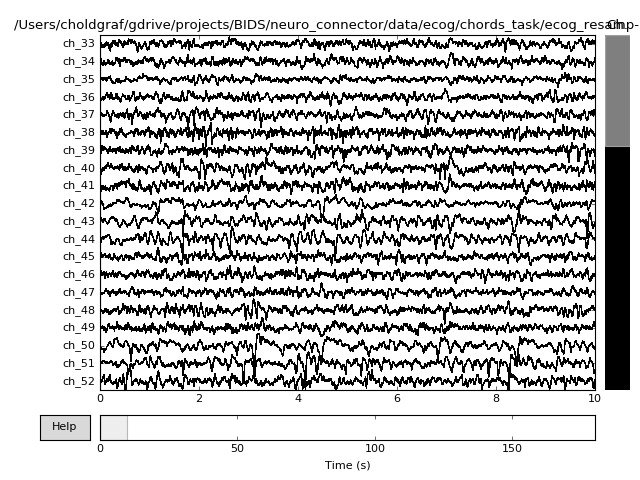

In [13]:
# As always, we'll begin by looking at the raw data.
# This time try to tell if channels are correlated with one another
_ = data.plot(scalings='auto')

Remember - correlations between two signals mean that when one signal is larger, the other also tends to be larger, and vice versa.

In [14]:
# We'll pick two neighboring channels at random, and construct a correlation matrix between them:
ch_a = data._data[10]
ch_b = data._data[11]
np.corrcoef(ch_a, ch_b)[1, 0]

0.29121749822817172

In [15]:
# Let's compare that with a third channel that isn't right next to the other two:
ch_c = data._data[60]
np.corrcoef(ch_a, ch_c)[1, 0]

-0.008387804101794398

> **Why do you think these two correlation values are different?**

To quickly look at the correlation between all of the channels, we can construct a "correlation matrix".

This is a matrix where each channel is correlated with all the other channels.

The output is a (channels x channels) matrix, that is symmetric about its diagonal:

In [16]:
cc_mat = np.corrcoef(data._data)
print(cc_mat.shape)

(64, 64)


<IPython.core.display.Javascript object>


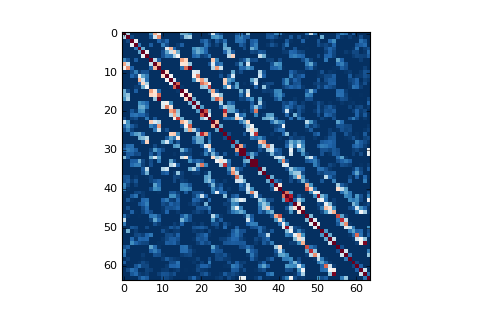

In [17]:
f, ax = plt.subplots()
ax.imshow(cc_mat, vmin=0, vmax=.5, cmap=plt.cm.RdBu_r, interpolation='nearest')

> **What kind of structure do you see in this image?**

> **What do you think that it means?**

> **Do you think we get more information from correlated channels, or uncorrelated channels?**

> **Why do you think two channels are correlated?**

<IPython.core.display.Javascript object>


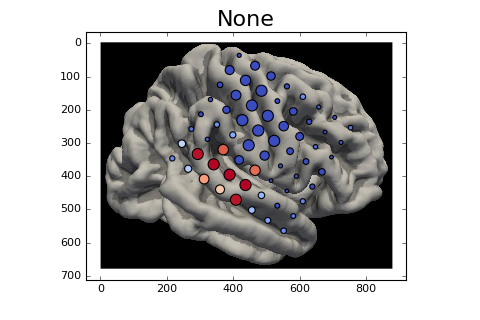

In [18]:
# We can pull out one row of the correlation matrix.
# This is one channel's correlation with all other channels.
# Since we have the 2d locations of channels, we can visualize this
cc_elec = cc_mat[25]

# We'll load the x/y positions of the sensors so we can plot on the brain
path_ecog = '../../data/ecog/chords_task/'
xy = ds.Table.read_table(path_ecog + 'brain_points.csv')
lt = mne.channels.read_layout('brain', path_ecog)
im = plt.imread(path_ecog + 'brain.png')

# This is a helper function to plot activity per electrode on the brain
nds.viz.plot_activity_on_brain(xy['x'], xy['y'], cc_elec, im, vmin=0, vmax=.2)

# Using regression to ask more complex questions
If we want to do something more complex than looking at pairwise relationships between signals (like the correlation matrix above) then we are going to need regression.

Regression is powerful because of how flexible it is. The only thing we need to do is define input variables, and find a set of weights that mixes them together to predict an output variable. This means that we can use multiple input variables for a single output variable, something called **multiple regression**.

Recall that we calculated Global Field Power as a marker for how much activity there was overall among the electrodes. But how can we tell which electrodes are contributing the most to this global field power? We can accomplish this by investigating the weights that we fit with a regression.

In [19]:
# We'll begin by loading event times for this dataset
time = ds.Table.read_table(path_ecog + 'meta_time.csv', index_col=0)

In [20]:
# Convert our time onsets from seconds to time indices
ix_onsets = time['start'] * data.info['sfreq']
ix_onsets = np.round(ix_onsets).astype(int)
ix_types = np.where(time['type'] == 'consonant', 1, 2)
events = np.vstack([ix_onsets, np.ones_like(ix_onsets), ix_types]).T

The events passed to the Epochs constructor are not chronologically ordered.


/Users/choldgraf/anaconda/envs/python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


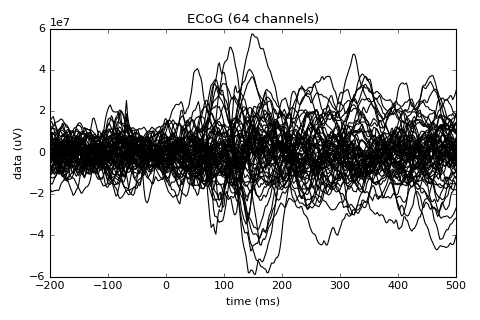

In [21]:
# As before, we could create an Epochs object, and calculate the average response for each one:
epochs = mne.Epochs(data, events, preload=True)
av = epochs.average()
_ = av.plot()

In [22]:
# Now calculate the global field power for these events
squared_ep = epochs._data ** 2
gfp_ep = squared_ep.mean(1)

# Now horizontally stack the epoched GFP / data so we can fit regressions
gfp = np.hstack(gfp_ep)
squared_raw = np.hstack(squared_ep)

> **What would happen if we just ran a regression where the output was GFP and the inputs were the values in `squared_av`?**

In order to get a set of weights that we can interpret, we must **scale** the input features first, so that they all have ~the same amplitude

In [23]:
# Finally, we can use regression to predict the GFP using channel data
X = scale(squared_raw, axis=1)
mod = LinearRegression(fit_intercept=False)
mod.fit(X.T, gfp[:, np.newaxis])

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [24]:
# The coefficients of this model represent how much each channel predicts GFP
coefs_raw = mod.coef_[0]
coefs_raw

array([  82.04040321,   86.87749647,   36.84468053,   62.23575316,
         89.27944228,   80.87557784,   83.46470495,  169.34408172,
        103.65200006,  133.84585322,  130.21012129,  112.06500563,
         53.08128571,   60.48585034,   52.23829123,   87.74971787,
         63.69789125,  156.00363158,  129.42893988,   98.24001015,
         69.64952762,   66.49614617,   61.89375761,   92.5844227 ,
         87.1765606 ,   46.5240976 ,   58.07217616,   77.13992743,
         83.38674436,   46.12294578,  102.34380685,   98.42614841,
         79.74717014,   30.88586214,   54.86748718,   72.75327452,
         70.92432683,   63.42902465,   52.37242342,  168.30620716,
         71.04143946,   36.99347821,   27.41140837,   34.82628626,
         53.7929    ,   33.04542624,   48.79735206,  200.50779249,
         49.51700816,   33.73991029,   22.60499283,   66.18343108,
         43.00182311,   62.84068903,   44.84383288,  111.78173452,
         34.44517383,   13.47434234,   46.67450177,   62.54990

Each coefficient is attached to a single ECoG channel. Its amplitude reflects the extent to which that channel is contributing to the global field potential.

<IPython.core.display.Javascript object>


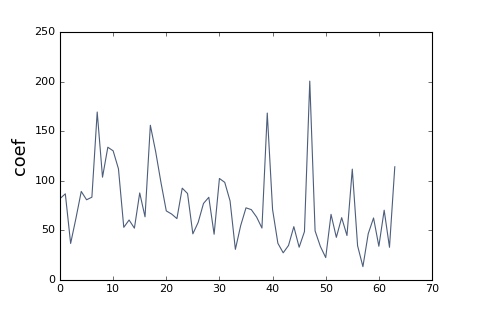

In [29]:
# Visualizing the variables is easier
tab = ds.Table().with_columns([('name', data.ch_names),
                               ('coef', coefs_raw)])
tab.plot(select='coef')

We'll visualize this on the brain with a helper function.

<IPython.core.display.Javascript object>


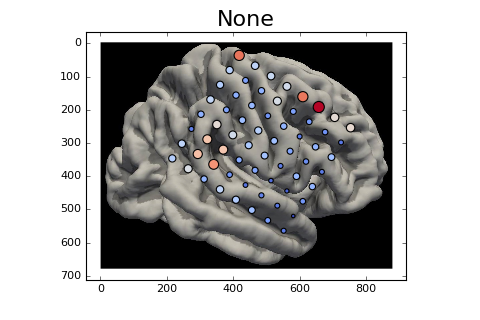

In [26]:
nds.viz.plot_activity_on_brain(xy['x'], xy['y'], mod.coef_[0], im)

<IPython.core.display.Javascript object>


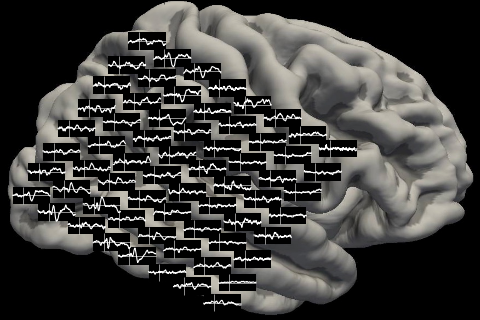

In [27]:
# Now let's see if that matches with the ERPs for this subject
fig = av.plot_topo(lt, fig_background=im)


* Do you see a perfect match between the two?
* What are some reasons that you can think of for a channel to be a large contributor to Global Field Power?